In [247]:
# 我们着重讨论不同区域的显著性影响因素
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [248]:
data = pd.read_csv("C:/Users/Zxzx/Desktop/新加坡暑期项目/Big-Data-Analytics-and-Visualization/data_cleaned.csv")
data.describe()

Lng            Lat           Cid      followers  \
count  297597.000000  297597.000000  2.975970e+05  297597.000000   
mean      116.418767      39.949761  1.126275e+12       0.015039   
std         0.110999       0.091533  1.331619e+12       0.030417   
min       116.072514      39.627030  1.111030e+12       0.000000   
25%       116.345863      39.893200  1.111030e+12       0.000000   
50%       116.416780      39.934530  1.111030e+12       0.004374   
75%       116.476921      40.003156  1.111030e+12       0.016623   
max       116.711337      40.252758  1.184870e+14       1.000000   

               price     livingRoom    drawingRoom        kitchen  \
count  297597.000000  297597.000000  297597.000000  297597.000000   
mean        0.391045       2.011102       1.171107       0.995131   
std         0.178332       0.764922       0.512581       0.100335   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.258747       1.000000       1.000000       1.000000   
50%         0.357607       2.000000       1.000000       1.000000   
75%         0.485556       2.000000       1.000000       1.000000   
max         1.000000       8.000000       5.000000       3.000000   

            bathRoom          floor  ...  renovationCondition  \
count  297597.000000  297597.000000  ...        297597.000000   
mean        1.182351      13.165916  ...             2.616461   
std         0.423099       7.764060  ...             1.306988   
min         0.000000       1.000000  ...             1.000000   
25%         1.000000       6.000000  ...             1.000000   
50%         1.000000      11.000000  ...             3.000000   
75%         1.000000      19.000000  ...             4.000000   
max         7.000000      63.000000  ...             4.000000   

       buildingStructure    ladderRatio       elevator         subway  \
count      297597.000000  297597.000000  297597.000000  297597.000000   
mean            4.421473       0.381856       0.570624       0.602388   
std             1.907456       0.176411       0.494988       0.489405   
min             1.000000       0.014000       0.000000       0.000000   
25%             2.000000       0.250000       0.000000       0.000000   
50%             6.000000       0.333000       1.000000       1.000000   
75%             6.000000       0.500000       1.000000       1.000000   
max             6.000000       5.000000       1.000000       1.000000   

            district  communityAverage  tradeTimeModefiy  Original_price  \
count  297597.000000     297597.000000     297597.000000   297597.000000   
mean        6.748516      63696.710585     735621.421896    42715.008611   
std         2.811945      22153.499402        597.390522    19476.512214   
min         1.000000      10847.000000     734046.000000        7.000000   
25%         6.000000      46505.000000     735124.000000    28266.000000   
50%         7.000000      59025.000000     735769.000000    39063.000000   
75%         8.000000      75858.000000     736091.000000    53037.000000   
max        13.000000     183109.000000     736628.000000   109222.000000   

       Original_followers  
count       297597.000000  
mean            17.189713  
std             34.766471  
min              0.000000  
25%              0.000000  
50%              5.000000  
75%             19.000000  
max           1143.000000  

[8 rows x 22 columns]

In [249]:
data.shape

(297597, 23)

In [250]:
data['totalRoom'] = data['livingRoom'] + data['drawingRoom'] + data['kitchen'] + data['bathRoom']
data['houseAge'] = data['tradeTimeModefiy']//365 - data['constructionTime']
data['houseCondition'] = data['renovationCondition'] + data['subway'] + data['elevator'] 

In [251]:
import folium
# 创建地图对象，设置初始位置和缩放级别
m = folium.Map(location=[39.906217, 116.3912757], zoom_start=13)
# 在地图上添加一个标记点
folium.Marker([39.906217, 116.3912757], popup='Beijing').add_to(m)
display(m)

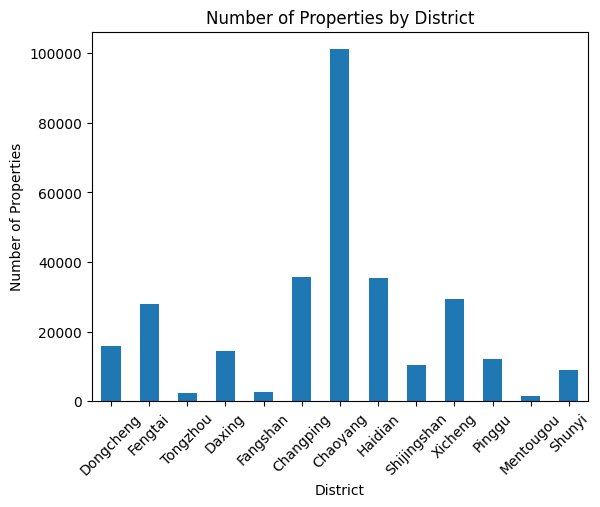

In [252]:
# 对district进行分组并计算每个区域的样本个数
district_counts = data.groupby('district').size()
# 绘制柱状图
district_counts.plot(kind='bar')

plt.xlabel('District')
plt.ylabel('Number of Properties')
plt.title('Number of Properties by District')
plt.xticks(range(len(district_counts)), ['Dongcheng', 'Fengtai', 'Tongzhou', 'Daxing', 'Fangshan', 'Changping', 'Chaoyang', 'Haidian', 'Shijingshan', 'Xicheng', 'Pinggu', 'Mentougou', 'Shunyi'], rotation=45)
plt.show()

In [253]:
# 我们把followers和price两个属性合并到一个新的属性中来衡量一个房产的受欢迎程度(这里的系数确定是根据分析DOM数据得到的)
# 根据我们在数据预处理部分得到的相关系数,price和DOM的相关性为0.215,followers和DOM的相关性为0.465我们合并得到一个attractiveness属性
data['attractiveness'] = 0.215/(0.215+0.465) * data['price'] + 0.465/(0.215+0.465) * data['followers']
data.drop(['price', 'followers'], axis=1, inplace=True)
data['attractiveness'].head()

0    0.065693
1    0.062300
2    0.058461
3    0.053882
4    0.158964
Name: attractiveness, dtype: float64

In [254]:
# 我们分区块研究影响房价的显著因素
# 东城区
from folium.plugins import MarkerCluster
Dongcheng_data = data[data['district'] == 1]
map_center = [Dongcheng_data.iloc[0]['Lat'], Dongcheng_data.iloc[0]['Lng']]
m = folium.Map(location=map_center, zoom_start=12)
# 创建一个 MarkerCluster 对象
marker_cluster = MarkerCluster().add_to(m)
# 遍历为每个点添加标记到 MarkerCluster 中，而不是直接添加到地图上
for index, row in Dongcheng_data.iterrows():
    folium.Marker([row['Lat'], row['Lng']]).add_to(marker_cluster)
display(m)

In [255]:
from folium.plugins import HeatMap
# 东城区
# 我们先观察房屋价格在地理空间中的分布情况
map_center = [Dongcheng_data.iloc[0]['Lat']-0.03, Dongcheng_data.iloc[0]['Lng']]
m = folium.Map(location=map_center, zoom_start=12)
# 权重设置为每个点的price
heat_data = [[row['Lat'], row['Lng'], row['attractiveness']] for index, row in Dongcheng_data.iterrows()]
# 创建热度图并添加到地图上，使用price作为权重
HeatMap(heat_data,blur=4, radius=8).add_to(m)
m

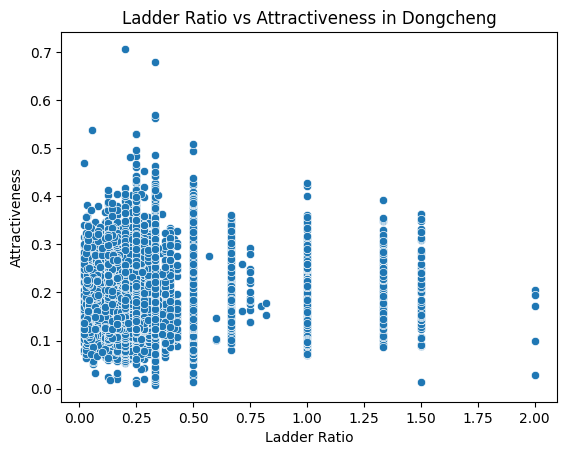

In [256]:
# 我们在东城区的范围内研究房价的显著影响因素
# 东城区
import seaborn as sns
# 使用Seaborn绘制ladderRatio与attarctiveness的关系
sns.scatterplot(data=Dongcheng_data, x='ladderRatio', y='attractiveness')
plt.title('Ladder Ratio vs Attractiveness in Dongcheng')
plt.xlabel('Ladder Ratio')
plt.ylabel('Attractiveness')
plt.show()

In [257]:
# 计算ladderRatio和attractiveness之间的相关系数
correlation_matrix = Dongcheng_data[['ladderRatio', 'attractiveness']].corr()
# 打印相关系数矩阵
print(correlation_matrix)
# 从相关系数的角度看一般条件下ladderRatio在东城区不是一个显著影响房屋吸引力的因素

                ladderRatio  attractiveness
ladderRatio        1.000000        0.063338
attractiveness     0.063338        1.000000


In [258]:
# 我们再观察东城区的房价与楼层高度的关系
high_floor = Dongcheng_data[Dongcheng_data['floor'] > 10]
low_floor = Dongcheng_data[Dongcheng_data['floor'] <= 10]
print("东城区高层建筑共{high_floor}个，低层建筑共{low_floor}个,高层建筑占比为{high_floor_ratio:.2f}%".format(high_floor=len(high_floor), low_floor=len(low_floor), high_floor_ratio=len(high_floor)/len(Dongcheng_data)*100))

东城区高层建筑共8286个，低层建筑共7677个,高层建筑占比为51.91%


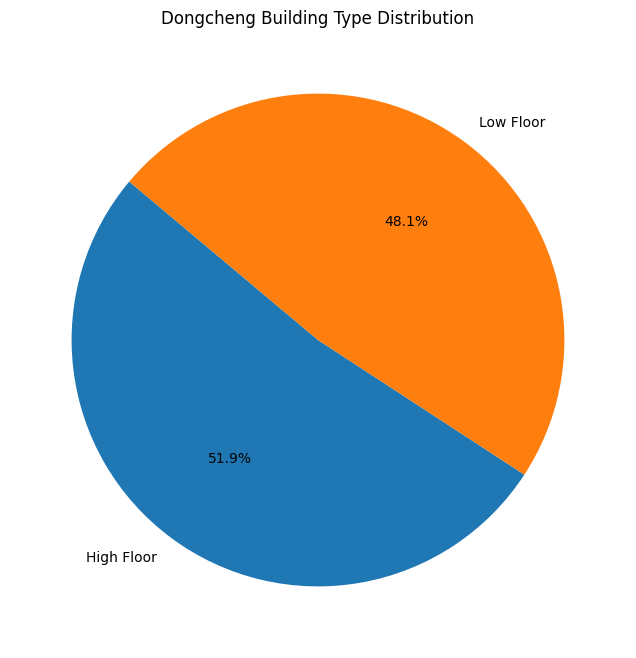

In [259]:
# 绘制饼图
plt.figure(figsize=(8, 8))
plt.pie([len(high_floor), len(low_floor)], labels=['High Floor', 'Low Floor'], autopct='%1.1f%%', startangle=140)
plt.title('Dongcheng Building Type Distribution')
plt.show()

In [260]:
# 计算floor和attractivness之间的相关系数
correlation_matrix = Dongcheng_data[['floor', 'attractiveness']].corr()
print(correlation_matrix)

                   floor  attractiveness
floor           1.000000       -0.065437
attractiveness -0.065437        1.000000


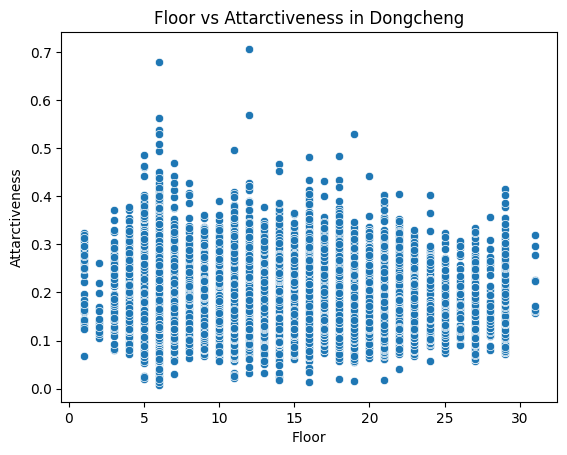

In [261]:
# 我们在东城区的范围内研究房价的显著影响因素
# 东城区
# 使用Seaborn绘制ladderRatio与attarctiveness的关系
sns.scatterplot(data=Dongcheng_data, x='floor', y='attractiveness')
plt.title('Floor vs Attarctiveness in Dongcheng')
plt.xlabel('Floor')
plt.ylabel('Attarctiveness')
plt.show()

In [262]:
# 发现在东城区中整体上floor和房屋的受欢迎程度没有关联
# 计算在高层条件下ladderRatio和attractiveness之间的相关系数
correlation_matrix = high_floor[['ladderRatio', 'attractiveness']].corr()
print(correlation_matrix)

                ladderRatio  attractiveness
ladderRatio        1.000000        0.083164
attractiveness     0.083164        1.000000


In [263]:
correlation_matrix = low_floor[['ladderRatio', 'attractiveness']].corr()
print(correlation_matrix)
# 对于低层建筑, ladderRatio和attractiveness之间的关联性相较于高层建筑要更弱,虽然面对高层建筑时人们会考虑人均楼梯数目但总体来说不显著

                ladderRatio  attractiveness
ladderRatio        1.000000        0.028868
attractiveness     0.028868        1.000000


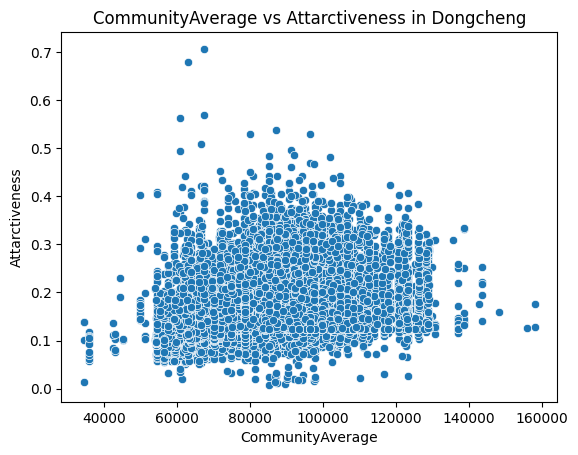

In [264]:
sns.scatterplot(data=Dongcheng_data, x='communityAverage', y='attractiveness')
plt.title('CommunityAverage vs Attarctiveness in Dongcheng')
plt.xlabel('CommunityAverage')
plt.ylabel('Attarctiveness')
plt.show()

In [265]:
# 研究communityAverage与attractiveness之间的关联度
correlation_matrix = Dongcheng_data[['communityAverage', 'attractiveness']].corr()
print(correlation_matrix)

                  communityAverage  attractiveness
communityAverage          1.000000        0.233072
attractiveness            0.233072        1.000000


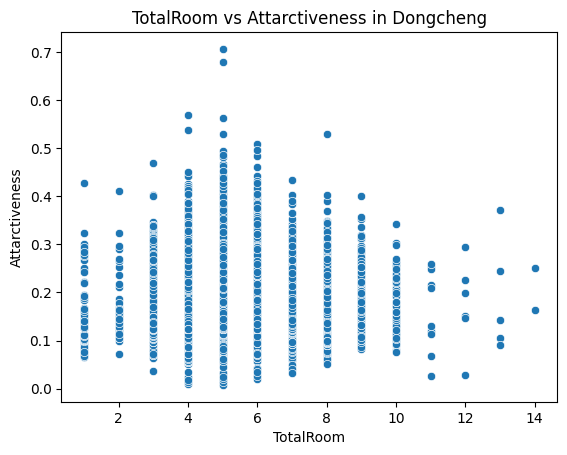

In [266]:
sns.scatterplot(data=Dongcheng_data, x='totalRoom', y='attractiveness')
plt.title('TotalRoom vs Attarctiveness in Dongcheng')
plt.xlabel('TotalRoom')
plt.ylabel('Attarctiveness')
plt.show()

In [267]:
# 研究totalRoom与attractiveness之间的关联度
correlation_matrix = Dongcheng_data[['totalRoom', 'attractiveness']].corr()
print(correlation_matrix)

                totalRoom  attractiveness
totalRoom         1.00000        -0.00651
attractiveness   -0.00651         1.00000


In [268]:
# 研究totalRoom与attractiveness之间的关联度
correlation_matrix = Dongcheng_data[['totalRoom', 'attractiveness']].corr()
print(correlation_matrix)

                totalRoom  attractiveness
totalRoom         1.00000        -0.00651
attractiveness   -0.00651         1.00000


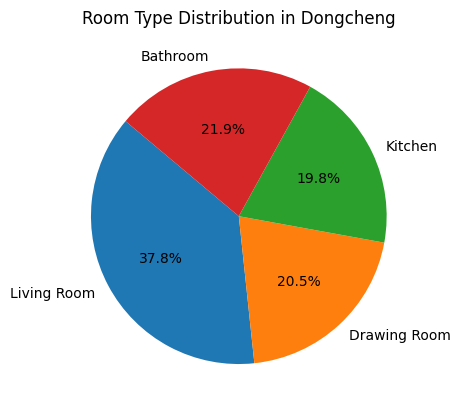

In [269]:
# 分别计算每种房间的总数
total_livingRoom = Dongcheng_data['livingRoom'].sum()
total_drawingRoom = Dongcheng_data['drawingRoom'].sum()
total_kitchen = Dongcheng_data['kitchen'].sum()
total_bathroom = Dongcheng_data['bathRoom'].sum()
# 将计算结果合并为一个新的Series
room_totals = pd.Series({
    'Living Room': total_livingRoom,
    'Drawing Room': total_drawingRoom,
    'Kitchen': total_kitchen,
    'Bathroom': total_bathroom
})
room_totals.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Room Type Distribution in Dongcheng')
plt.ylabel('')
plt.show()

In [270]:
# 我们从一般的角度出发研究房间类型对吸引力的影响
correlation_matrix = Dongcheng_data[['bathRoom','kitchen','drawingRoom','livingRoom' ,'attractiveness']].corr()
print(correlation_matrix)

                bathRoom   kitchen  drawingRoom  livingRoom  attractiveness
bathRoom        1.000000  0.206071     0.493859    0.423999       -0.026945
kitchen         0.206071  1.000000     0.167915    0.103960        0.005492
drawingRoom     0.493859  0.167915     1.000000    0.389559       -0.024780
livingRoom      0.423999  0.103960     0.389559    1.000000        0.015097
attractiveness -0.026945  0.005492    -0.024780    0.015097        1.000000


In [271]:
big_family = Dongcheng_data[Dongcheng_data['livingRoom'] >= 3]
# 我们再进一步研究大的家庭对不同种类房间的需求
correlation_matrix = big_family[['bathRoom','kitchen','drawingRoom', 'attractiveness']].corr()
print(correlation_matrix)

                bathRoom   kitchen  drawingRoom  attractiveness
bathRoom        1.000000  0.075476     0.621126       -0.062656
kitchen         0.075476  1.000000     0.093153       -0.008966
drawingRoom     0.621126  0.093153     1.000000       -0.082005
attractiveness -0.062656 -0.008966    -0.082005        1.000000


In [272]:
small_family = Dongcheng_data[Dongcheng_data['livingRoom'] < 3]
correlation_matrix = small_family[['bathRoom','kitchen','drawingRoom', 'attractiveness']].corr()
print(correlation_matrix)

                bathRoom   kitchen  drawingRoom  attractiveness
bathRoom        1.000000  0.310937     0.322709       -0.021367
kitchen         0.310937  1.000000     0.183950        0.008915
drawingRoom     0.322709  0.183950     1.000000       -0.011756
attractiveness -0.021367  0.008915    -0.011756        1.000000


In [273]:
# 交易时房龄对吸引力的影响
correlation_matrix = Dongcheng_data[['constructionTime','houseAge','attractiveness']].corr()
print(correlation_matrix)

                  constructionTime  houseAge  attractiveness
constructionTime          1.000000 -0.986445       -0.009111
houseAge                 -0.986445  1.000000        0.121889
attractiveness           -0.009111  0.121889        1.000000


In [274]:
correlation_matrix = Dongcheng_data[['houseCondition','houseAge','constructionTime','attractiveness']].corr()
print(correlation_matrix)

                  houseCondition  houseAge  constructionTime  attractiveness
houseCondition          1.000000 -0.182610          0.276602        0.353487
houseAge               -0.182610  1.000000         -0.986445        0.121889
constructionTime        0.276602 -0.986445          1.000000       -0.009111
attractiveness          0.353487  0.121889         -0.009111        1.000000


In [275]:
correlation_matrix = high_floor[['elevator','attractiveness']].corr()
print(correlation_matrix)

                elevator  attractiveness
elevator          1.0000          0.0095
attractiveness    0.0095          1.0000


C:\Users\Zxzx\AppData\Local\Temp\ipykernel_19688\1398381951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dongcheng_data['buildingType'] = Dongcheng_data['buildingType'].map(type_mapping)


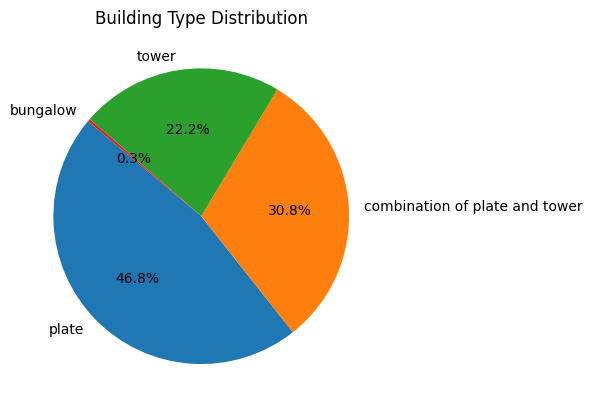

In [276]:
type_mapping = {
    1: 'tower',
    2: 'bungalow',
    3: 'combination of plate and tower',
    4: 'plate'
}
Dongcheng_data['buildingType'] = Dongcheng_data['buildingType'].map(type_mapping)
building_type_counts = Dongcheng_data['buildingType'].value_counts()
building_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Building Type Distribution')
plt.ylabel('')
plt.show()

buildingType
bungalow                          0.207263
plate                             0.186317
combination of plate and tower    0.180186
tower                             0.173355
Name: attractiveness, dtype: float64


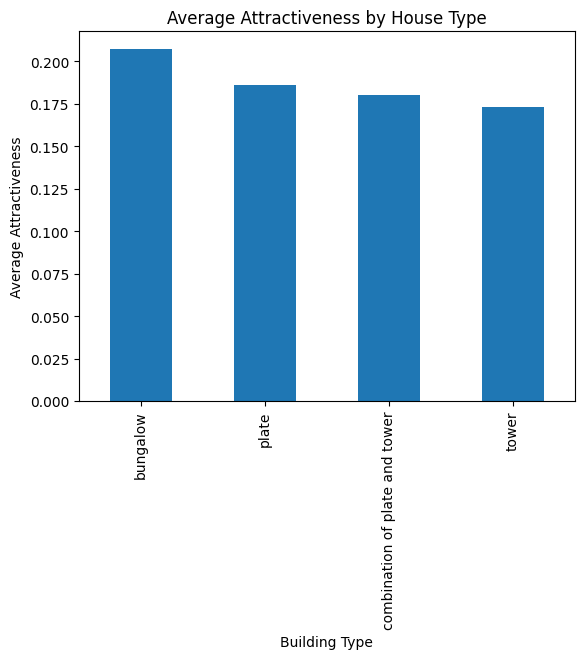

In [277]:
# 计算每种房屋建筑结构类型的attractiveness平均值
attractiveness_avg = Dongcheng_data.groupby('buildingType')['attractiveness'].mean().sort_values(ascending=False)
print(attractiveness_avg)
attractiveness_avg.plot(kind='bar')
plt.title('Average Attractiveness by House Type')
plt.xlabel('Building Type')
plt.ylabel('Average Attractiveness')
plt.show()

In [278]:
Dongcheng_data= Dongcheng_data[Dongcheng_data['buildingStructure']!=1]
Dongcheng_data['buildingStructure']

67        6
81        2
92        6
94        2
133       6
         ..
297485    6
297508    6
297512    2
297576    2
297585    6
Name: buildingStructure, Length: 15962, dtype: int64

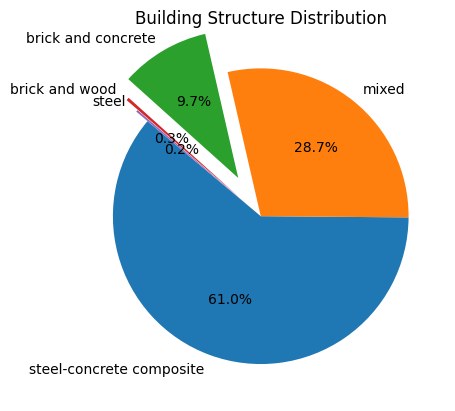

In [279]:
type_mapping = {
    2:"mixed",
    3:"brick and wood", 
    4:"brick and concrete", 
    5:"steel", 
    6:"steel-concrete composite"
}
Dongcheng_data['buildingStructure'] = Dongcheng_data['buildingStructure'].map(type_mapping)
building_type_counts = Dongcheng_data['buildingStructure'].value_counts()
explode_values = (0, 0, 0.3, 0.2, 0.1)
building_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, explode=explode_values)
plt.title('Building Structure Distribution')
plt.ylabel('')
plt.show()

buildingStructure
brick and wood              0.208281
mixed                       0.184128
brick and concrete          0.182810
steel-concrete composite    0.180097
steel                       0.177963
Name: attractiveness, dtype: float64


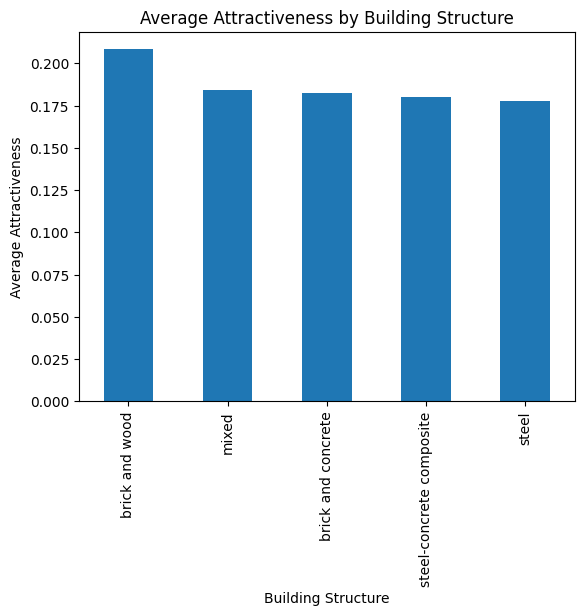

In [280]:
# 计算每种房屋建筑结构类型的attractiveness平均值
attractiveness_avg = Dongcheng_data.groupby('buildingStructure')['attractiveness'].mean().sort_values(ascending=False)
print(attractiveness_avg)
attractiveness_avg.plot(kind='bar')
plt.title('Average Attractiveness by Building Structure')
plt.xlabel('Building Structure')
plt.ylabel('Average Attractiveness')
plt.show()